### Problem Statement
Mining companies face problems regarding the impurities present in Ore. More the impurities poorer the ore. 
In this problem we have to classify the **Grade** (quality) of Iron ore at the end process based on Silica present. <br/> 
Grade 1- Supreme Quality<br/>
Grade 2- Good Quality<br/>
Grade 3- Average Quality<br/>
Grade 4- Poor Quality

### Installing required packages

In [1]:
!pip install lime
!pip install eli5
!pip install shap

## Import the required Libraries

In [2]:
import pandas as pd
import pandas_profiling
import dask.dataframe as dd
pd.options.display.max_columns=False
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# import lime
# import eli5
# import shap
%matplotlib inline

**Import the data set**

In [4]:
#from google.colab import files
#files.upload()

**Read the data with dask**

In [15]:
%time
dask_train = dd.read_csv('attachment_Iron_mining_lyst2076.xls',decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()     # Reading data using dask

Wall time: 0 ns


**Read the data using pandas** 

In [16]:
%time
df=pd.read_csv('attachment_Iron_mining_lyst2076.xls',decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()

Wall time: 0 ns


In [17]:
df.shape

(5000, 26)

In [18]:
df.head()

,Unnamed: 0,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,grade
0,677134,2017-08-27 00:00:00,63.64,3.77,2409.63,473.908,379.6564666667,9.22212,1.6901400000000002,300.645,295.45799999999997,301.54200000000003,299.07099999999997,300.904,293.225,300.605,411.80699999999996,504.19199999999995,399.356,429.865,427.22,399.01199999999994,380.20599999999996,65.99,1.04,2
1,529548,2017-07-23 20:00:00,57.44,14.09,3495.86,514.526,396.18199999999996,9.79135,1.7230400000000001,250.028,250.683,248.112,295.5314085145,294.7101342844,250.11599999999999,247.1,391.533,424.436,400.81,493.259,467.586,482.836,519.243,65.95,1.6,2
2,88250,2017-04-12 17:00:00,56.77,11.98,2074.22,548.706,400.781,9.88895,1.7402900000000001,250.457,250.269,248.95,296.1734384164,302.6528399183,252.68599999999998,248.73,605.09,704.043,593.506,451.95300000000003,443.93,468.769,473.408,64.35,2.64,3
3,714298,2017-09-04 15:00:00,54.14,14.69,1122.4509565217,477.284,382.7133333333,9.46836,1.61796,299.475,308.325,297.949,300.029,298.075,302.343,292.639,397.824,595.765,400.61699999999996,342.079,422.61199999999997,594.885,391.319,64.25,2.3,3
4,710528,2017-09-03 18:00:00,55.99,15.13,3266.57,525.784,378.7435,9.81666,1.71947,301.465,303.307,299.475,294.1870792079,289.5262690139,358.421,331.56699999999995,626.692,584.185,594.794,205.167,334.202,361.733,321.123,64.69,3.02,4


**Exploratory Data Analysis**

In [19]:
del df['Unnamed: 0']                                                                     # Lets drop the unnamed column

In [20]:
df.info()                                                                                # Check the info of the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          5000 non-null   datetime64[ns]
 1   % Iron Feed                   5000 non-null   object        
 2   % Silica Feed                 5000 non-null   object        
 3   Starch Flow                   5000 non-null   object        
 4   Amina Flow                    5000 non-null   object        
 5   Ore Pulp Flow                 5000 non-null   object        
 6   Ore Pulp pH                   5000 non-null   object        
 7   Ore Pulp Density              5000 non-null   object        
 8   Flotation Column 01 Air Flow  5000 non-null   object        
 9   Flotation Column 02 Air Flow  5000 non-null   object        
 10  Flotation Column 03 Air Flow  5000 non-null   object        
 11  Flotation Column 04 Air Flow  

**Feature Extraction**<br/>
Extract Hour, Month and Day columns from Date column

In [21]:
df['Hour']=df['date'].dt.hour
df['Month']=df['date'].dt.month

In [22]:
df['day']=df['date'].dt.dayofweek

In [23]:
df['day'].value_counts()                                                        # Day counts across the data set

4    735
0    732
2    718
6    716
5    710
3    708
1    681
Name: day, dtype: int64

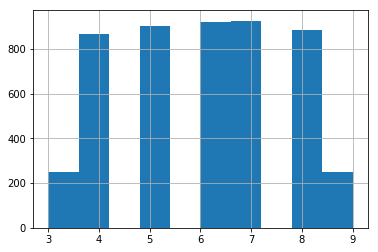

In [0]:
df['Month'].hist()

In [24]:
del df['date']                                                                  # We can delete date column as it's not required any longer

**Let's check shape, missing values and data types of the variables**

In [25]:
print('Shape of the data \n',df.shape)
print('###############--------------')
print('Find Missing values if present\n',df.isnull().sum())
print('###############--------------')
print('Datatype\n',df.dtypes)

Shape of the data 
 (5000, 27)
###############--------------
Find Missing values if present
 % Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
grade                           0
Hour                            0
Month                           0
day                    

**Converting columns having object data type into numeric ones**

In [26]:
new_df=df.iloc[:,:-5].astype(float)

In [27]:
new_df1=pd.concat([new_df,df.iloc[:,-4:]],axis=1)                             # Merging all the numeric columns

In [0]:
round(new_df1.head(),2)

,Unnamed: 0,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,grade,Hour,Month,day
0,677134.0,63.64,3.77,2409.63,473.91,379.66,9.22,1.69,300.64,295.46,301.54,299.07,300.90,293.23,300.60,411.81,504.19,399.36,429.86,427.22,399.01,380.21,65.99,2,0,8,6
1,529548.0,57.44,14.09,3495.86,514.53,396.18,9.79,1.72,250.03,250.68,248.11,295.53,294.71,250.12,247.10,391.53,424.44,400.81,493.26,467.59,482.84,519.24,65.95,2,20,7,6
2,88250.0,56.77,11.98,2074.22,548.71,400.78,9.89,1.74,250.46,250.27,248.95,296.17,302.65,252.69,248.73,605.09,704.04,593.51,451.95,443.93,468.77,473.41,64.35,3,17,4,2
3,714298.0,54.14,14.69,1122.45,477.28,382.71,9.47,1.62,299.48,308.32,297.95,300.03,298.08,302.34,292.64,397.82,595.76,400.62,342.08,422.61,594.88,391.32,64.25,3,15,9,0
4,710528.0,55.99,15.13,3266.57,525.78,378.74,9.82,1.72,301.46,303.31,299.48,294.19,289.53,358.42,331.57,626.69,584.18,594.79,205.17,334.20,361.73,321.12,64.69,4,18,9,6


**Let's take a look at the Descriptive Statistics of the data set**

In [28]:
new_df1.describe().T

,count,mean,std,min,25%,50%,75%,max
% Iron Feed,5000.0,56.287182,5.123272,42.740000,52.670000,55.990000,59.660000,65.780000
% Silica Feed,5000.0,14.660398,6.736497,1.310000,8.990000,14.090000,19.580000,33.400000
Starch Flow,5000.0,2885.549793,1226.564669,0.926983,2077.735156,3022.215000,3748.682500,6294.080000
Amina Flow,5000.0,487.692110,92.871891,242.160938,428.023750,504.115000,554.013750,736.939876
Ore Pulp Flow,5000.0,397.470851,9.570733,376.310000,394.331250,399.288500,402.819500,418.638000
Ore Pulp pH,5000.0,9.771589,0.388677,8.753376,9.522980,9.802825,10.042600,10.807700
Ore Pulp Density,5000.0,1.679455,0.069558,1.519884,1.646155,1.697062,1.726485,1.848503
Flotation Column 01 Air Flow,5000.0,280.657171,29.216536,175.955087,250.286500,299.359500,300.146000,368.932750
Flotation Column 02 Air Flow,5000.0,277.157805,29.926332,177.130000,250.414750,296.042000,300.686000,366.708000
Flotation Column 03 Air Flow,5000.0,281.650409,28.057315,177.192455,250.973500,298.696500,300.435500,310.301000


**Pandas profiling**

In [ ]:
report=pandas_profiling.ProfileReport(new_df1)
report

**Correlation plot**

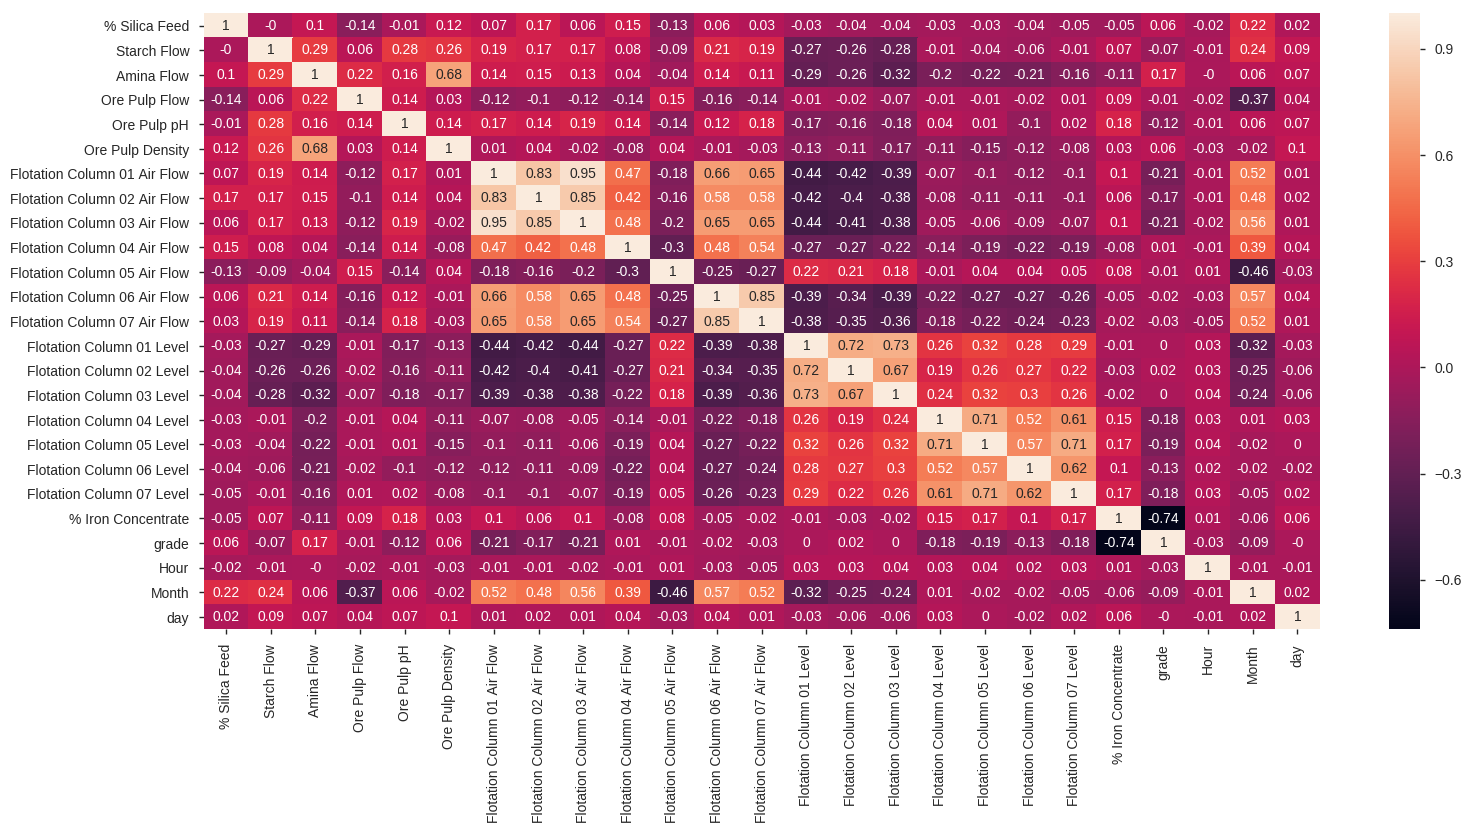

In [0]:

plt.figure(figsize=[18,8])
sns.heatmap(round(new_df1.iloc[:,1:].corr(),2),annot=True)
plt.show()

**Boxplot:**<br/> Check outliers across the variables

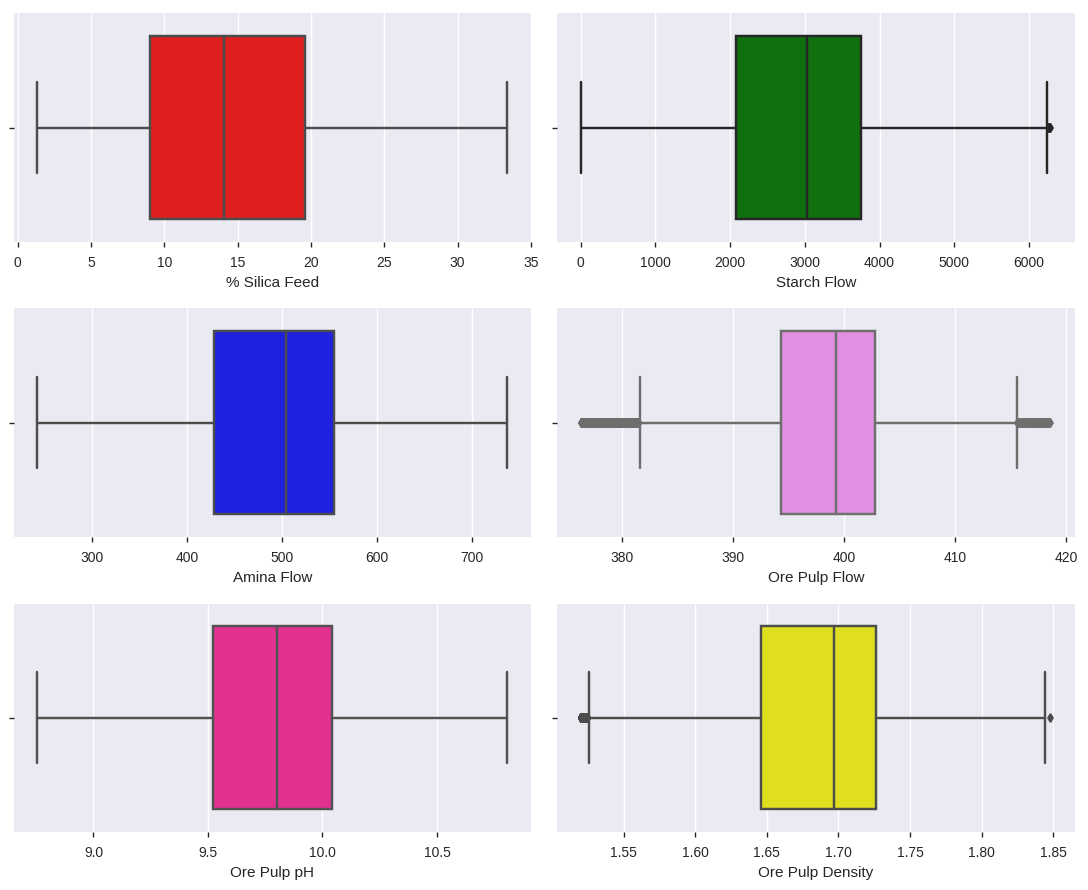

In [0]:
# Checking the box plot of the first 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.boxplot(new_df1.iloc[:,1],color='r')
plt.subplot(322)
sns.boxplot(new_df1.iloc[:,2],color='g')
plt.subplot(323)
sns.boxplot(new_df1.iloc[:,3],color='b')
plt.subplot(324)
sns.boxplot(new_df1.iloc[:,4],color='violet')
plt.subplot(325)
sns.boxplot(new_df1.iloc[:,5],color='deeppink')
plt.subplot(326)
sns.boxplot(new_df1.iloc[:,6],color='yellow')
plt.tight_layout()
plt.show()

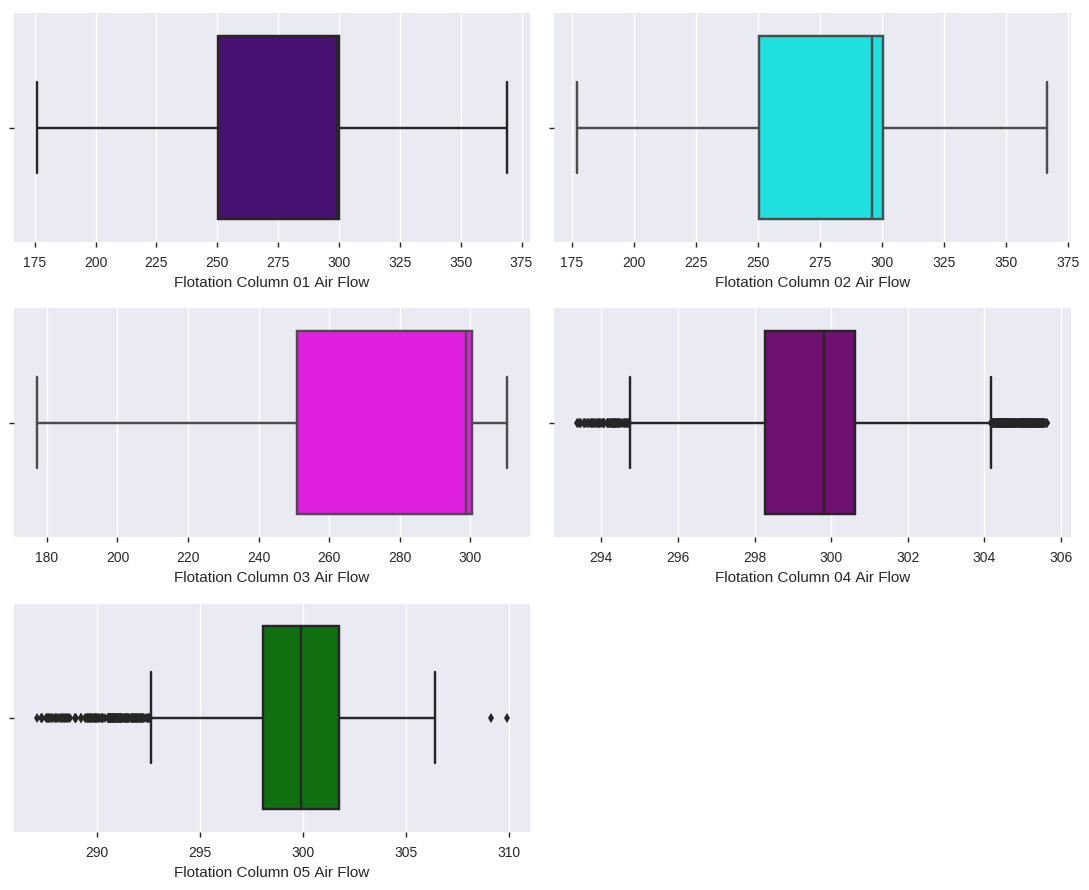

In [0]:
# Checking the box plot of the next 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.boxplot(new_df1.iloc[:,7],color='indigo')
plt.subplot(322)
sns.boxplot(new_df1.iloc[:,8],color='cyan')
plt.subplot(323)
sns.boxplot(new_df1.iloc[:,9],color='magenta')
plt.subplot(324)
sns.boxplot(new_df1.iloc[:,10],color='purple')
plt.subplot(325)
sns.boxplot(new_df1.iloc[:,11],color='green')
plt.tight_layout()
plt.show()

**Observation** : From the quartile division, it is pretty evident that data points across the vairiables are consistent, i.e. no influence of outliers, though standard deviation in most of the variables is large. 

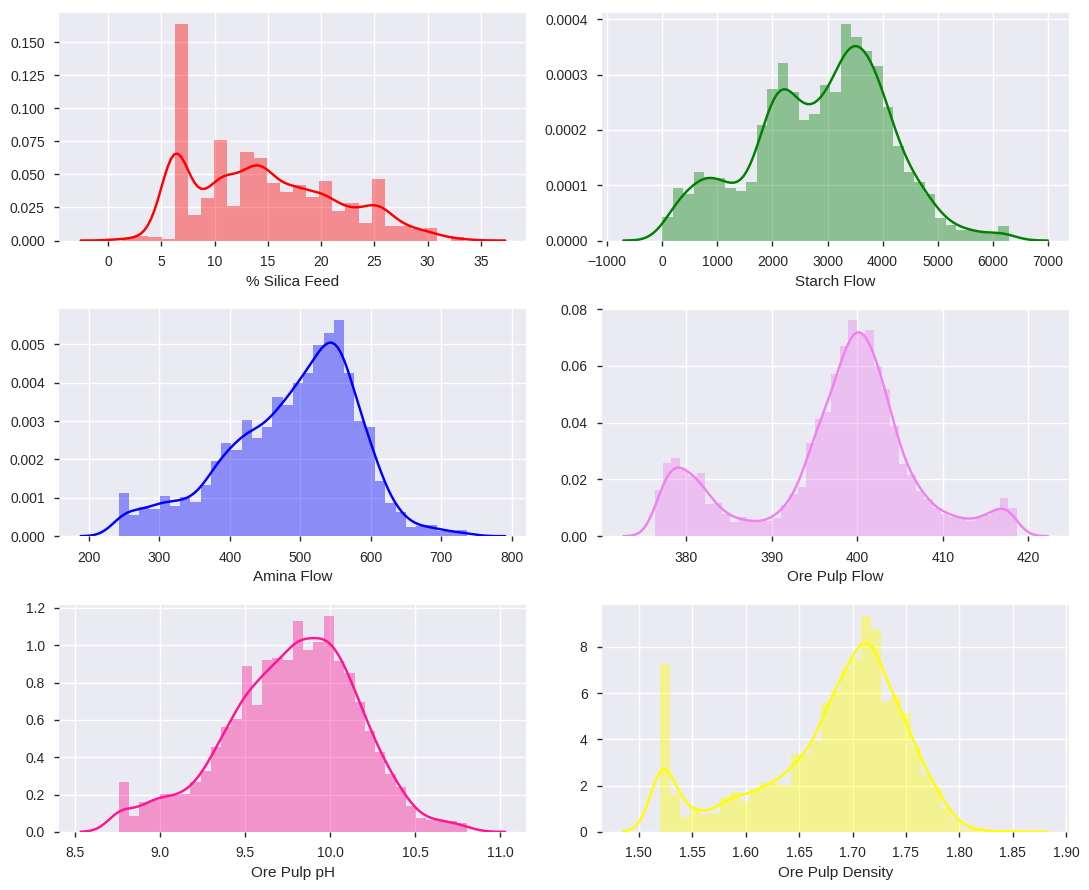

In [0]:
# Checking the histigram of the first 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.distplot(new_df1.iloc[:,1],color='r')
plt.subplot(322)
sns.distplot(new_df1.iloc[:,2],color='g')
plt.subplot(323)
sns.distplot(new_df1.iloc[:,3],color='b')
plt.subplot(324)
sns.distplot(new_df1.iloc[:,4],color='violet')
plt.subplot(325)
sns.distplot(new_df1.iloc[:,5],color='deeppink')
plt.subplot(326)
sns.distplot(new_df1.iloc[:,6],color='yellow')
plt.tight_layout()
plt.show()

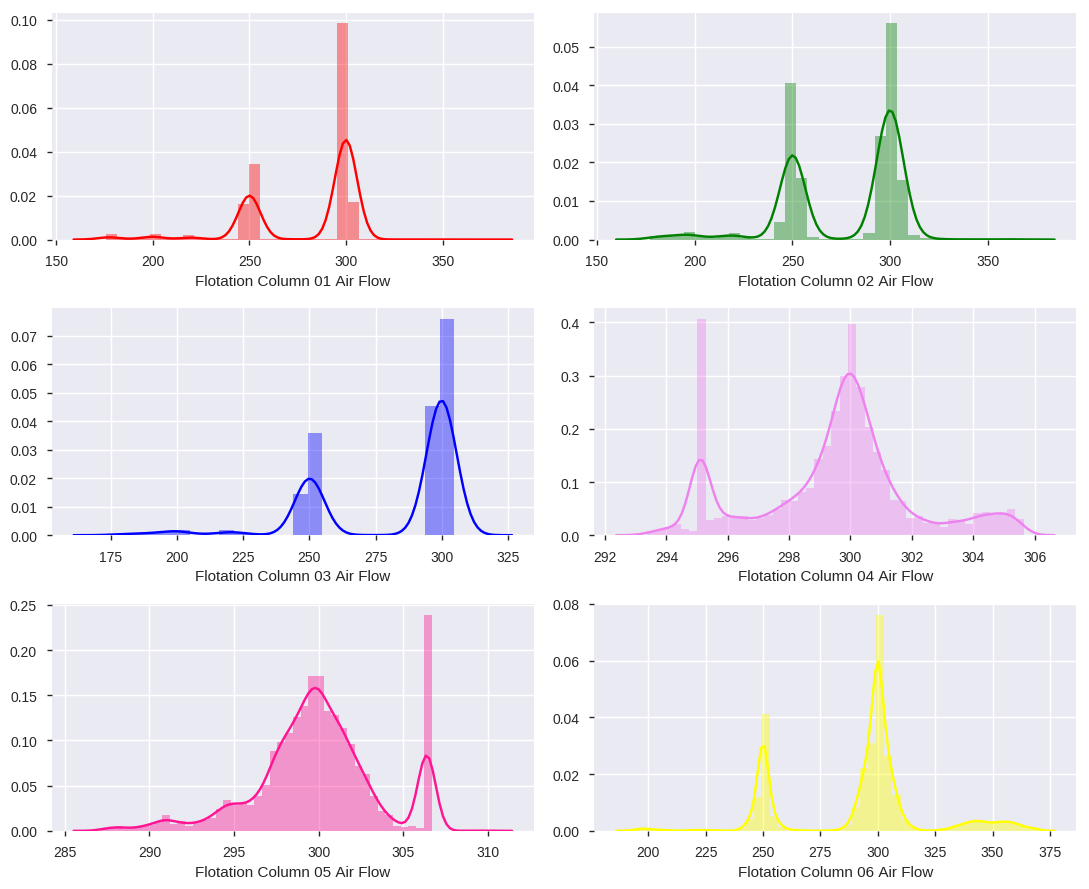

In [0]:
# Checking the histogram of the next 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.distplot(new_df1.iloc[:,7],color='r')
plt.subplot(322)
sns.distplot(new_df1.iloc[:,8],color='g')
plt.subplot(323)
sns.distplot(new_df1.iloc[:,9],color='b')
plt.subplot(324)
sns.distplot(new_df1.iloc[:,10],color='violet')
plt.subplot(325)
sns.distplot(new_df1.iloc[:,11],color='deeppink')
plt.subplot(326)
sns.distplot(new_df1.iloc[:,12],color='yellow')
plt.tight_layout()
plt.show()

In [31]:
new_df1['grade'].value_counts()                                                 # Frequency of each of 4 categories

2    2437
3    1285
4    1258
1      20
Name: grade, dtype: int64

**Creating the features and the labels**

In [32]:
y=new_df1.loc[:,'grade']
new_df1.drop(['grade'],axis=1,inplace=True)
x=new_df1

**Dummy encode the categorical columns**

In [33]:
cols=['Hour','Month','day']                                                      # These are the categorical columns
cat_cols=x[cols]
cat_cols=cat_cols.astype(str)

In [34]:
dummies=pd.get_dummies(cat_cols,drop_first=True)

In [35]:
dummies.head()

,Hour_1,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_2,Hour_20,Hour_21,Hour_22,Hour_23,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [36]:
input_features=pd.concat([x,dummies],axis=1)                                     # Concat the dummy variables with x(Input features)

In [38]:
input_features.shape                                                             # Now we have 5000 rows and 60 columns

(5000, 60)

**Train-Test split for training and validation**

In [41]:
x_train,x_test,y_train,y_test=train_test_split(input_features,y,test_size=0.2,random_state=1234)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 60)
(1000, 60)
(4000,)
(1000,)


##Training models

**Logistic Regression**

In [42]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=101)

In [43]:
lr_model=lr.fit(x_train,y_train)

In [44]:
lr_pred=lr_model.predict(x_test)

0.524
********************************************
Confusion matrix


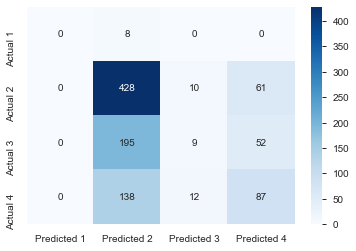

**********************************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.56      0.86      0.68       499
           3       0.29      0.04      0.06       256
           4       0.43      0.37      0.40       237

    accuracy                           0.52      1000
   macro avg       0.32      0.31      0.28      1000
weighted avg       0.46      0.52      0.45      1000



In [46]:
print(metrics.accuracy_score(y_test,lr_pred))
print('********************************************')
print('Confusion matrix')
lr_cfm=metrics.confusion_matrix(y_test, lr_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(lr_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('**********************************************')
print(metrics.classification_report(y_test,lr_pred))

**Decision Tree classifier**

In [0]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, min_samples_leaf =3, random_state=101)

In [0]:
dt_model=dt.fit(x_train,y_train)
dt_pred=dt_model.predict(x_test)

0.763
***************************************
Confusion matrix


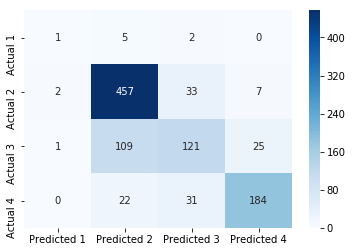

****************************************
              precision    recall  f1-score   support

           1       0.25      0.12      0.17         8
           2       0.77      0.92      0.84       499
           3       0.65      0.47      0.55       256
           4       0.85      0.78      0.81       237

    accuracy                           0.76      1000
   macro avg       0.63      0.57      0.59      1000
weighted avg       0.75      0.76      0.75      1000



In [0]:
print(metrics.accuracy_score(y_test,dt_pred))
print('***************************************')
print('Confusion matrix')
dt_cfm=metrics.confusion_matrix(y_test, dt_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(dt_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('****************************************')
print(metrics.classification_report(y_test,dt_pred))

**RandomForest with Grid Search**

In [49]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(oob_score=True)

#### GridSearchCV

In [50]:
random_grid = {'n_estimators': range(5,20,3),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [5,10,20,30],
              'min_samples_split':[2,5,10],
              'criterion':['entropy'],
              'min_samples_leaf':[1,2,4]}

rf = RandomForestClassifier()

rf_gs = GridSearchCV(rf, random_grid, cv = 5, n_jobs=-1, verbose=2)

rf_gs.fit(x_train, y_train)
y_pred = rf_gs.predict(x_test)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   41.1s finished


0.803
*******************************************
Confusion matrix


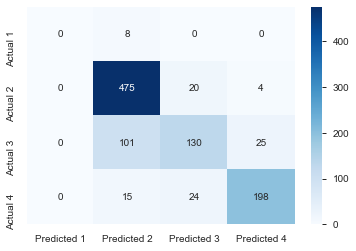

********************************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.79      0.95      0.87       499
           3       0.75      0.51      0.60       256
           4       0.87      0.84      0.85       237

    accuracy                           0.80      1000
   macro avg       0.60      0.57      0.58      1000
weighted avg       0.79      0.80      0.79      1000



In [51]:
print(metrics.accuracy_score(y_test,y_pred))
print('*******************************************')
print('Confusion matrix')
rf_cfm=metrics.confusion_matrix(y_test, y_pred)

lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(rf_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('********************************************')
print(metrics.classification_report(y_test,y_pred))

**XGBoost**<br/>

In [52]:
from xgboost.sklearn import XGBClassifier

In [53]:
xgb_model = XGBClassifier(num_class = 4,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42) 

In [54]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=42, subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [55]:
xgboost_pred=xgb_model.predict(x_test)

0.789
************
Confusion matrix


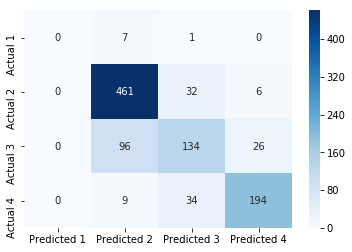

************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.80      0.92      0.86       499
           3       0.67      0.52      0.59       256
           4       0.86      0.82      0.84       237

    accuracy                           0.79      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.78      0.79      0.78      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print(metrics.accuracy_score(y_test,xgboost_pred))
print('************')
print('Confusion matrix')
xgboost_cm=metrics.confusion_matrix(y_test, xgboost_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(xgboost_cm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('************\n Classification report')
print(metrics.classification_report(y_test,xgboost_pred))

**XgBoost with Grid Search**

In [57]:
xgb_gs_clf = XGBClassifier(num_class = 4,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42)                         
                        
param_grid = {"max_depth": [10,15,20,30],
              "n_estimators": range(5,20,2) , 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}
#              "min_child_weight": [5,10], 
#              "colsample_bytree": [0.4,0.8], 
#              "subsample": [0.50,0.85]} 

grid_search = GridSearchCV(xgb_gs_clf, 
                           param_grid=param_grid,
                           cv = 5,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_c...
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=42, subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
        

In [58]:
xgboost_y_pred=grid_search.predict(x_test)                                      # Validating the model by predicting the test data

0.823
*************************************************
Confusion matrix


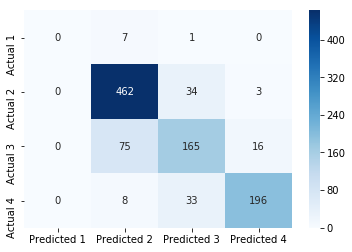

***************************************************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.84      0.93      0.88       499
           3       0.71      0.64      0.67       256
           4       0.91      0.83      0.87       237

    accuracy                           0.82      1000
   macro avg       0.61      0.60      0.61      1000
weighted avg       0.81      0.82      0.82      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print(metrics.accuracy_score(y_test,xgboost_y_pred))
print('*************************************************')
print('Confusion matrix')
xgboost_cfm=metrics.confusion_matrix(y_test, xgboost_y_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(xgboost_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,xgboost_y_pred))

**LightGBM**

In [59]:
import lightgbm as lgb

d_train= lgb.Dataset(x_train, label = y_train)                                        # LightGBM dataset format

In [60]:
params = {}
params['learning_rate'] = 0.01                                             # Learning rate
params['boosting_type'] = 'gbdt'                                           # gbdt = gradient boosted decision tree
params['objective'] = 'multiclass'                                         # Multi class classification
params['metric'] = 'multi_logloss'
params['num_classes'] = 5 
#params['sub_feature'] = 0.5
#params['min_data'] = 50
#params['max_depth'] = 10


clf = lgb.train(params, d_train)                                                      # Training the model for 10 iterations

In [61]:
#Prediction
y_pred=clf.predict(x_test)

In [62]:
predictions = []

for x in y_pred:
    predictions.append(np.argmax(x))

In [63]:
lgb_y_pred = np.array(predictions)

In [ ]:
print(metrics.accuracy_score(y_test,lgb_y_pred))
print('*************************************************')
print('Confusion matrix')
lgb_cfm=metrics.confusion_matrix(y_test, lgb_y_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(lgb_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,lgb_y_pred))

In [ ]:
y_train.value_counts()

#### Model interpretability using Eli5 and SHAP

In [ ]:
eli5.show_weights(xgboost_model,feature_names=x_train.columns.values)

In [ ]:
eli5.explain_prediction(xgboost_model,x_test.iloc[1])

In [ ]:
y_test.iloc[1]

In [ ]:
eli5.explain_prediction(xgboost_model,x_test.iloc[30])

In [ ]:
y_test.iloc[30]

In [ ]:
import shap

In [ ]:
xgboost_explainer_shap=shap.TreeExplainer(xgboost_model)

In [ ]:
print('Actual label\n',y_test[1])
print('******')
shap_values1=xgboost_explainer_shap.shap_values(x_test.iloc[1])
data_to_predict1 = x_test.iloc[1]
shap.initjs()
shap.force_plot(xgboost_explainer_shap.expected_value[2],shap_values1[2],data_to_predict1)

In [ ]:
print('Actual label\n',y_test[1])
print('******')
shap_values30=xgboost_explainer_shap.shap_values(x_test.iloc[30])
data_to_predict30 = x_test.iloc[30]
shap.initjs()
shap.force_plot(xgboost_explainer_shap.expected_value[1],shap_values30[1],data_to_predict30)